In [1]:
import numpy as np


In [2]:
def gradient(func, x):
    eps = np.finfo(float).eps
    g = (func(x + eps) - func(x)) / eps
    return g

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

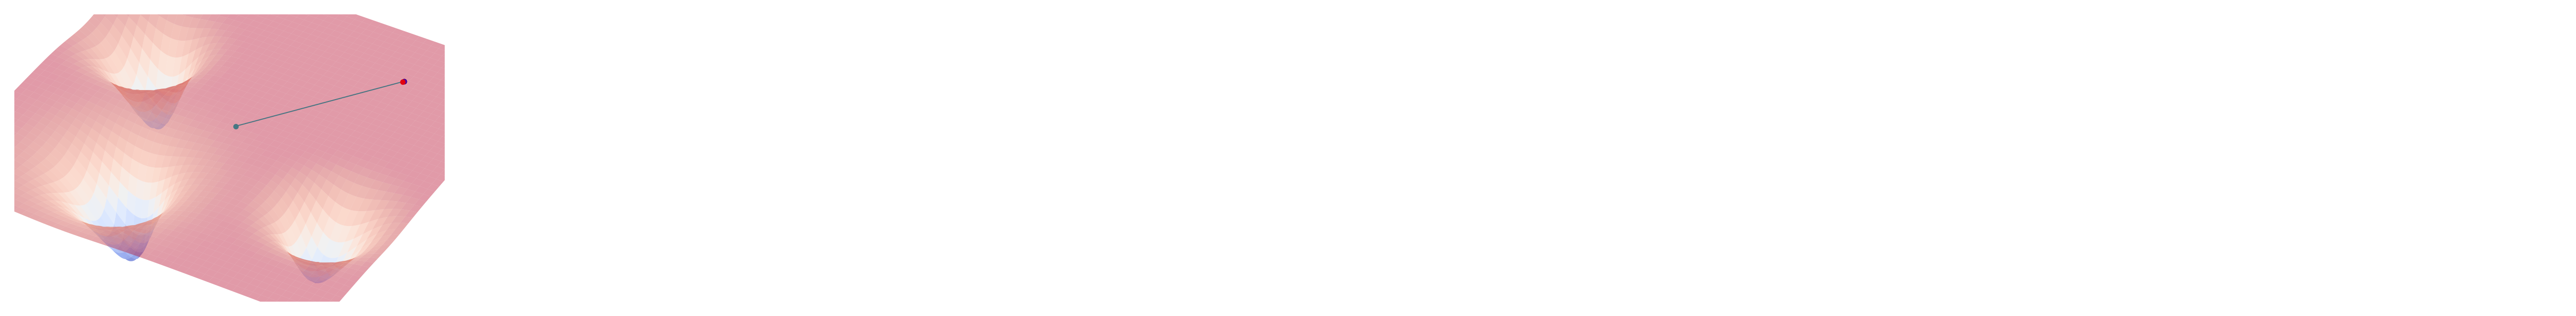

In [3]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


# cost function
def cost_func(x=None, y=None):
    '''Cost function.
    For visualizing contour plot, call f() and collect placeholder nodes for fast GPU calc.
    To incorporate variables to optimize, pass them in as argument to attach as x and y.
    Args:
        x: None if placeholder tensor is used as input. Specify x to use x as input tensor.
        y: None if placeholder tensor is used as input. Specify y to use y as input tensor.
    Returns:
        Tuple (x, y, z) where x and y are input tensors and z is output tensor.
    '''
    if not x:
        x = tf.placeholder(tf.float32, shape=[None, 1])
    if not y:
        y = tf.placeholder(tf.float32, shape=[None, 1])

    # two local minima near (0, 0)
#     z = __f1(x, y)

    # 3rd local minimum at (-0.5, -0.8)
    z = -1 * __f2(x, y, x_mean=-0.5, y_mean=-0.8, x_sig=0.35, y_sig=0.35)

    # one steep gaussian trench at (0, 0)
#     z -= __f2(x, y, x_mean=0, y_mean=0, x_sig=0.2, y_sig=0.2)

    # three steep gaussian trenches
    z -= __f2(x, y, x_mean=1.0, y_mean=-0.5, x_sig=0.2, y_sig=0.2)
    z -= __f2(x, y, x_mean=-1.0, y_mean=0.5, x_sig=0.2, y_sig=0.2)
    z -= __f2(x, y, x_mean=-0.5, y_mean=-0.8, x_sig=0.2, y_sig=0.2)

    return x, y, z


# noisy hills of the cost function
def __f1(x, y):
    return -1 * tf.sin(x * x) * tf.cos(3 * y * y) * tf.exp(-(x * y) * (x * y)) - tf.exp(-(x + y) * (x + y))


# bivar gaussian hills of the cost function
def __f2(x, y, x_mean, y_mean, x_sig, y_sig):
    normalizing = 1 / (2 * np.pi * x_sig * y_sig)
    x_exp = (-1 * tf.square(x - x_mean)) / (2 * tf.square(x_sig))
    y_exp = (-1 * tf.square(y - y_mean)) / (2 * tf.square(y_sig))
    return normalizing * tf.exp(x_exp + y_exp)


# pyplot settings
plt.ion()
fig = plt.figure(figsize=(3, 2), dpi=300)
ax = fig.add_subplot(111, projection='3d')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
params = {'legend.fontsize': 3,
          'legend.handlelength': 3}
plt.rcParams.update(params)
plt.axis('off')

# input (x, y) and output (z) nodes of cost-function graph
x, y, z = cost_func()

# visualize cost function as a contour plot
x_val = y_val = np.arange(-1.5, 1.5, 0.005, dtype=np.float32)
x_val_mesh, y_val_mesh = np.meshgrid(x_val, y_val)
x_val_mesh_flat = x_val_mesh.reshape([-1, 1])
y_val_mesh_flat = y_val_mesh.reshape([-1, 1])
with tf.Session() as sess:
    z_val_mesh_flat = sess.run(z, feed_dict={x: x_val_mesh_flat, y: y_val_mesh_flat})
z_val_mesh = z_val_mesh_flat.reshape(x_val_mesh.shape)
levels = np.arange(-10, 1, 0.05)
# ax.contour(x_val_mesh, y_val_mesh, z_val_mesh, levels, alpha=.7, linewidths=0.4)
# ax.plot_wireframe(x_val_mesh, y_val_mesh, z_val_mesh, alpha=.5, linewidths=0.4, antialiased=True)
ax.plot_surface(x_val_mesh, y_val_mesh, z_val_mesh, alpha=.4, cmap=cm.coolwarm)
plt.draw()

# starting location for variables
x_i = 0.75
y_i = 1.0

# create variable pair (x, y) for each optimizer
x_var, y_var = [], []
for i in range(7):
    x_var.append(tf.Variable(x_i, [1], dtype=tf.float32))
    y_var.append(tf.Variable(y_i, [1], dtype=tf.float32))

# create separate graph for each variable pairs
cost = []
for i in range(7):
    cost.append(cost_func(x_var[i], y_var[i])[2])

# define method of gradient descent for each graph
# optimizer label name, learning rate, color
ops_param = np.array([['Adadelta', 50.0, 'b'],
                     ['Adagrad', 0.10, 'g'],
                     ['Adam', 0.05, 'r'],
                     ['Ftrl', 0.5, 'c'],
                     ['GD', 0.05, 'm'],
                     ['Momentum', 0.01, 'y'],
                     ['RMSProp', 0.02, 'k']])

ops = []
ops.append(tf.train.AdadeltaOptimizer(float(ops_param[0, 1])).minimize(cost[0]))
ops.append(tf.train.AdagradOptimizer(float(ops_param[1, 1])).minimize(cost[1]))
ops.append(tf.train.AdamOptimizer(float(ops_param[2, 1])).minimize(cost[2]))
ops.append(tf.train.FtrlOptimizer(float(ops_param[3, 1])).minimize(cost[3]))
ops.append(tf.train.GradientDescentOptimizer(float(ops_param[4, 1])).minimize(cost[4]))
ops.append(tf.train.MomentumOptimizer(float(ops_param[5, 1]), momentum=0.95).minimize(cost[5]))
ops.append(tf.train.RMSPropOptimizer(float(ops_param[6, 1])).minimize(cost[6]))

# 3d plot camera zoom, angle
xlm = ax.get_xlim3d()
ylm = ax.get_ylim3d()
zlm = ax.get_zlim3d()
ax.set_xlim3d(xlm[0] * 0.5, xlm[1] * 0.5)
ax.set_ylim3d(ylm[0] * 0.5, ylm[1] * 0.5)
ax.set_zlim3d(zlm[0] * 0.5, zlm[1] * 0.5)
azm = ax.azim
ele = ax.elev + 40
ax.view_init(elev=ele, azim=azm)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # use last location to draw a line to the current location
    last_x, last_y, last_z = [], [], []
    plot_cache = [None for _ in range(len(ops))]

    # loop each step of the optimization algorithm
    steps = 1000
    for iter in range(steps):
        for i, op in enumerate(ops):
            # run a step of optimization and collect new x and y variable values
            _, x_val, y_val, z_val = sess.run([op, x_var[i], y_var[i], cost[i]])

            # move dot to the current value
            if plot_cache[i]:
                plot_cache[i].remove()
            plot_cache[i] = ax.scatter(x_val, y_val, z_val, s=3, depthshade=True, label=ops_param[i, 0], color=ops_param[i, 2])

            # draw a line from the previous value
            if iter == 0:
                last_z.append(z_val)
                last_x.append(x_i)
                last_y.append(y_i)
            ax.plot([last_x[i], x_val], [last_y[i], y_val], [last_z[i], z_val], linewidth=0.5, color=ops_param[i, 2])
            last_x[i] = x_val
            last_y[i] = y_val
            last_z[i] = z_val

        if iter == 0:
            legend = np.vstack((ops_param[:, 0], ops_param[:, 1])).transpose()
            plt.legend(plot_cache, legend)

        plt.savefig('figures/' + str(iter) + '.png')
        print('iteration: {}'.format(iter))

        plt.pause(0.0001)

print("done")

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Oct 22 16:14:21 2018

@author: liyz
"""

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from function import *


def plotfunc(func,x):
    
    x = np.linspace(-x, x)
    y = x
    xx,yy = np.meshgrid(x,y)
    zz = func((xx,yy))
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ax.plot_surface(xx,yy,zz,
                    rstride=1, 
                    cstride=1, 
                    cmap='rainbow'
                    )
    
    ax.contourf(xx,yy,zz, zdir='z', offset=0, cmap='rainbow')
    plt.show()
    
if __name__ == '__main__':
    
#    plotfunc(sphere, 5.12)
#    plotfunc(rosenbrock, 2.048)
    plotfunc(rastrigin, 5.12)
#    plotfunc(griewank, 600)